In [6]:
## import functions

from Functions import *
import numpy as np

Import images

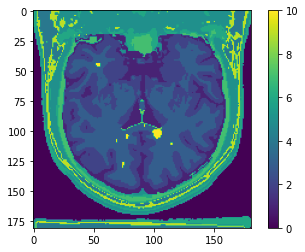

In [7]:
import rawpy
import numpy as np
from matplotlib import pylab as plt
import pandas

#T1-weighted MRI sequence
t1 = np.fromfile("t1.raw", dtype='uint8')
t1 = t1.reshape([181,181,217])

#T2-weighted MRI sequence
t2 = np.fromfile("t2.raw", dtype='uint8')
t2 = t2.reshape([181,181,217])

#Density-weighted MRI sequence
pd = np.fromfile("pd.raw", dtype='uint8')
pd = pd.reshape([181,181,217])

mask = np.fromfile("msk.raw", dtype='uint8')
mask = mask.reshape([181,181,217])

## Mask contains labels for brain tissues
# 1 - CSF (cerebrospinal fluid)
# 2 - GM (grey matter)
# 3 - WM (white matter)
# 10 - lesions (in analysis we will label lesions as 4)


# Mask image at z-axis 90
plt.imshow(mask[:,:,90])
plt.colorbar()

In [8]:
## Read only every 5th slice on z-axis
t1 = t1[:,:,::5]
t2 = t2[:,:,::5]
pd = pd[:,:,::5]
mask = mask[:,:,::5]


In [9]:
## input template: (t1,t2,pd,mask)
## input template for binary_mask_function: (mask,lesions=True/False)
## in this case we input True for lesions

combined,coordinates, group = combine_images(binary_mask_function(mask,True)[1],t1,t2,pd)

binary_mask,mask_2 = binary_mask_function(mask,True)
combined = np.array(combined)

In [10]:
## input template = (mask,imaxiter,ik,lesions=True/false,t1,t2,pd,)
## in this segment we are including lesions in our analysis, therefore number of clusters iK=4
## Goal is to segment CSF, WM, GM and lesions.


reconstructed_image, segmentedLabels, trueLabels = mrBrainSegmentation( mask ,20,4, True, t1,t2,pd )

[[ 51.         177.         199.        ]
 [ 98.66172392 101.09623807 179.93409633]
 [ 73.49968123 153.74255699 193.27161674]
 [114.19835175  83.64747419 173.28486233]]
[[ 45.23081687 196.1284145  205.1391225 ]
 [ 72.77696301 143.70352488 194.77148147]
 [ 94.60063646  96.30540898 187.77335038]
 [123.26941834  70.21397932 168.48658598]]
[[ 45.0544865  199.19983698 206.92595152]
 [ 69.90463753 143.8696824  192.53988719]
 [ 97.11720309  92.28863754 186.41093148]
 [127.59056636  67.58740607 165.55430279]]
[[ 45.15119339 200.21409774 207.71327534]
 [ 68.99157153 143.8869563  191.86008735]
 [ 98.26061553  90.81141182 185.49974923]
 [129.57062757  66.47905629 164.46359675]]
[[ 45.21535397 200.50050713 207.95694027]
 [ 68.81731986 143.75139616 191.6878056 ]
 [ 98.72866676  90.26247578 185.13712281]
 [130.26480154  66.09187616 164.08607705]]
[[ 45.23706387 200.56841366 208.0171681 ]
 [ 68.8509364  143.60123708 191.657814  ]
 [ 98.9098101   90.05220926 184.99594095]
 [130.50317368  65.95359278 1

In [11]:
np.unique(segmentedLabels)
# Lesions are labeled as 4 for easier presentation with colorbar

array([1., 2., 3., 4.])

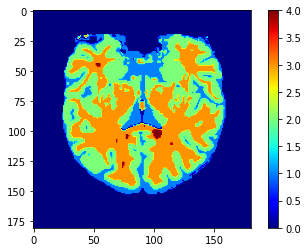

In [12]:
##Plot of mask_2 at z-axis 90

plt.imshow(mask_2[:,:,18],cmap="jet" )
plt.colorbar()
#plt.savefig('maplesions.png')


In [13]:
## labels are off in this case, we need to correct/swap them

lab1 = np.where(segmentedLabels == 1)
lab2 = np.where(segmentedLabels == 2)
lab3 = np.where(segmentedLabels == 3)
lab4 = np.where(segmentedLabels == 4)

segmentedLabels2 = segmentedLabels
segmentedLabels2[lab1]=1
segmentedLabels2[lab2]=4
segmentedLabels2[lab3]=2
segmentedLabels2[lab4]=3

def fix_reconstruction(rec):
    reconstructed_image = np.zeros((181,181,217//5))

    for i in range(180):
        for j in range(180):
            for k in range(217//5):
                if rec[i,j,k] == 2:
                    reconstructed_image[i,j,k]= 4
                elif  rec[i,j,k] == 4:   
                    reconstructed_image[i,j,k]= 3
                elif  rec[i,j,k] == 3:   
                    reconstructed_image[i,j,k]= 2   
                else:
                    reconstructed_image[i,j,k]=rec[i,j,k]
    return reconstructed_image  

reconstructed_image2 = fix_reconstruction(reconstructed_image)

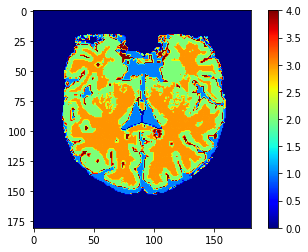

In [14]:
## Plot of reconstructe slice at z-axis 90
plt.imshow(reconstructed_image2[:,:,18],cmap="jet" )
plt.colorbar()
#plt.savefig('reconstructionlesions.png')

Segmentation of CSF, GM and WM was successful. Segmentation of lesions was very poor. 

In [15]:
computeDiceCoeff(trueLabels,segmentedLabels)

[0.8394331294044761,
 0.9046056600386674,
 0.9517926591670834,
 0.06598783698767388]

High score for CSF, GM, WM. Very low score for lesions.

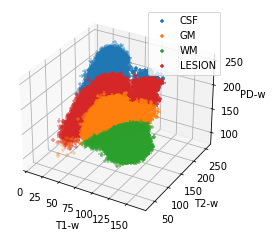

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(combined[np.where(segmentedLabels2==1),0], combined[np.where(segmentedLabels2==1),1], combined[np.where(segmentedLabels==1),2], marker='+',label='CSF');
ax.scatter(combined[np.where(segmentedLabels2==2),0], combined[np.where(segmentedLabels2==2),1], combined[np.where(segmentedLabels==2),2], marker='+',label='GM');
ax.scatter(combined[np.where(segmentedLabels2==3),0], combined[np.where(segmentedLabels==3),1], combined[np.where(segmentedLabels==3),2], marker='+',label='WM');
ax.scatter(combined[np.where(segmentedLabels2==4),0], combined[np.where(segmentedLabels==4),1], combined[np.where(segmentedLabels==4),2], marker='+',label='LESION');


ax.set_xlabel('T1-w')
ax.set_ylabel('T2-w')
ax.set_zlabel('PD-w')

ax.legend(loc='upper right')

#plt.savefig('seglesions.png')

3D feature space of pixels 